<a href="https://colab.research.google.com/github/kwangilkimkenny/AI_Research_nlp/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%A5%BC_%EB%B3%B4%EA%B3%A0_%EC%A7%88%EB%AC%B8%EC%97%90_%EB%8B%B5%ED%95%98%EB%8A%94_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_KoLLaVA_%EB%B9%B5%ED%98%95%EC%9D%98_%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지를 보고 질문에 답하는 인공지능 KoLLaVA

> 유튜브 [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

- GitHub https://github.com/tabtoyou/KoLLaVA
- HuggingFace https://huggingface.co/tabtoyou/KoLLaVA-KoVicuna-7b

![](https://github.com/tabtoyou/KoLLaVA/blob/main/images/demo_dog.png?raw=true)

## Check GPUs

Colab Pro (V100 or A100)

In [ ]:
!nvidia-smi

Sun Jul  9 03:53:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install dependencies

In [ ]:
!git clone -q https://github.com/tabtoyou/KoLLaVA.git
%cd KoLLaVA
!pip install -q --upgrade pip
!pip install -q -e .

/content/KoLLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from llava.model import *
from llava.model.utils import KeywordsStoppingCriteria

from PIL import Image

import os
import requests
from PIL import Image
from io import BytesIO


DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"

## Load a pretrained model

https://huggingface.co/tabtoyou/KoLLaVA-KoVicuna-7b

In [ ]:
model_name = 'tabtoyou/KoLLaVA-KoVicuna-7b'

# Load Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LlavaLlamaForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True, torch_dtype=torch.float16, use_cache=True).cuda()

image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)

mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

vision_tower = model.get_model().vision_tower[0]
vision_tower = CLIPVisionModel.from_pretrained(vision_tower.config._name_or_path, torch_dtype=torch.float16, low_cpu_mem_usage=True).cuda()
model.get_model().vision_tower[0] = vision_tower

vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_projection.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.8.self_attn.k_proj.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.5.layer_norm2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_projection.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.8.self_attn.k_proj.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.5.layer_norm2.

## Helper functions

In [ ]:
def load_image(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image


def inference(qs, image_file) :
  image = load_image(image_file)

  qs = qs + '\n' + DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN

  conv_mode = "multimodal"
  conv = conv_templates[conv_mode].copy()
  conv.append_message(conv.roles[0], qs)
  conv.append_message(conv.roles[1], None)
  prompt = conv.get_prompt()
  inputs = tokenizer([prompt])

  image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
  input_ids = torch.as_tensor(inputs.input_ids).cuda()

  stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
  keywords = [stop_str]
  stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

  with torch.inference_mode():
      output_ids = model.generate(
          input_ids,
          images=image_tensor.unsqueeze(0).half().cuda(),
          do_sample=True,
          temperature=0.2,
          max_new_tokens=1024,
          stopping_criteria=[stopping_criteria])

  input_token_len = input_ids.shape[1]
  n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()

  if n_diff_input_output > 0:
      print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
  outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
  outputs = outputs.strip()
  if outputs.endswith(stop_str):
      outputs = outputs[:-len(stop_str)]
  outputs = outputs.strip()

  return outputs

## Inference

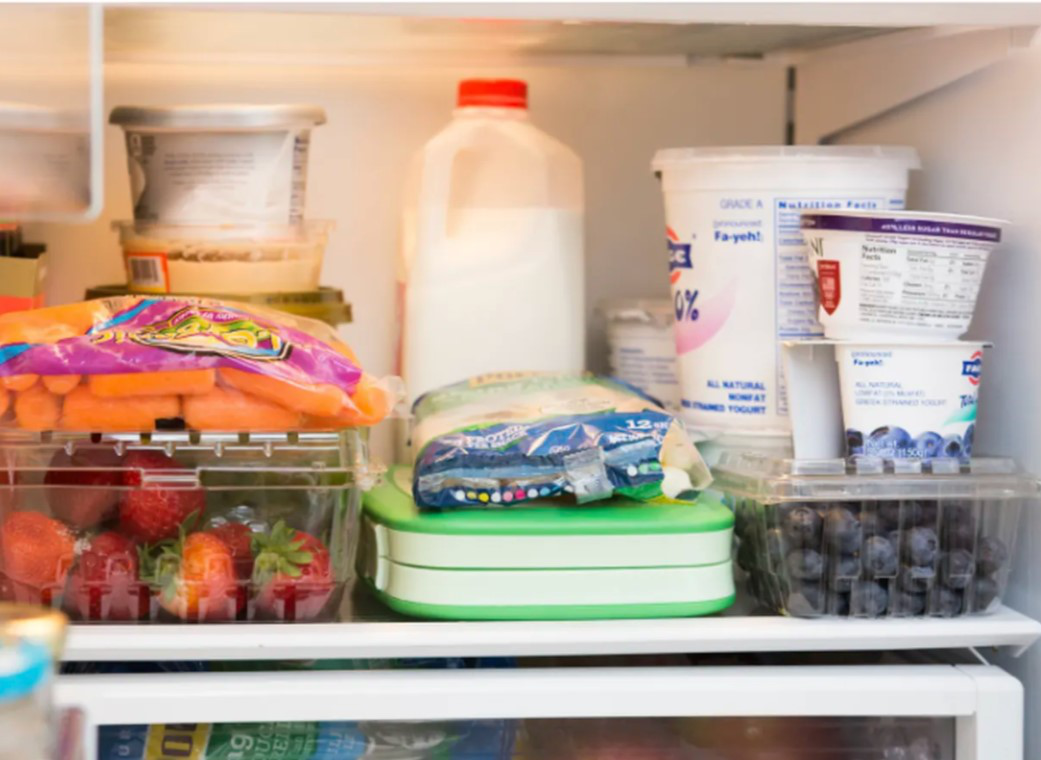

In [ ]:
image_file = "/content/KoLLaVA/images/food.png"

load_image(image_file)

In [ ]:
query = "어떤 재료들이 있나요?"

inference(query, image_file)

'냉장고에는 과일, 우유, 버터, 달걀, 주스 등 다양한 식품이 가득합니다.'

In [ ]:
query = "이미지 속 재료들로 만들 수 있는 음식 3가지 말해주세요."

inference(query, image_file)

'이미지에는 다양한 식품이 담긴 냉장고가 있습니다. 냉장고에는 블루베리, 딸기, 당근 등 다양한 과일과 채소가 들어 있습니다. 냉장고에는 병도 있습니다. 이러한 재료를 사용하여 만들 수 있는 세 가지 음식은 다음과 같습니다:\n\n1. 블루베리 딸기 샐러드: 블루베리, 딸기, 당근을 섞어 신선하고 상큼한 샐러드를 만들 수 있습니다. 딸기 샐러드에 얇게 썬 당근을 추가하면 더욱 풍미를 더할 수 있습니다.\n\n2. 블루베리 딸기 스무디: 블루베리와 딸기를 섞어 달콤하고 상큼한 스무디를 만들어 보세요. 당근을 추가하면 영양소와 풍미를 더할 수 있습니다.\n\n3. 블루베리 딸기 치즈 샌드위치: 블루베리와 딸기를 얇게 썰어 치즈와 함께 샌드위치 빵에 올려 맛있고 건강한 샌드위치를 만들어 보세요.\n\n이러한 재료를 사용하여 다양한 건강 식사와 간식을 만들 수 있습니다.'

이미지에는 다양한 식품이 담긴 냉장고가 있습니다. 냉장고에는 블루베리, 딸기, 당근 등 다양한 과일과 채소가 들어 있습니다. 냉장고에는 병도 있습니다. 이러한 재료를 사용하여 만들 수 있는 세 가지 음식은 다음과 같습니다:

1. 블루베리 딸기 샐러드: 블루베리, 딸기, 당근을 섞어 신선하고 상큼한 샐러드를 만들 수 있습니다. 딸기 샐러드에 얇게 썬 당근을 추가하면 더욱 풍미를 더할 수 있습니다.
2. 블루베리 딸기 스무디: 블루베리와 딸기를 섞어 달콤하고 상큼한 스무디를 만들어 보세요. 당근을 추가하면 영양소와 풍미를 더할 수 있습니다.
3. 블루베리 딸기 치즈 샌드위치: 블루베리와 딸기를 얇게 썰어 치즈와 함께 샌드위치 빵에 올려 맛있고 건강한 샌드위치를 만들어 보세요.\n\n이러한 재료를 사용하여 다양한 건강 식사와 간식을 만들 수 있습니다.

In [ ]:
query = "먹으면 위험한 음식이 있나요?"

inference(query, image_file)

'네, 냉장고에는 많은 음식이 들어 있으며 일부는 위험할 수 있습니다. 냉장고에는 블루베리, 딸기, 당근, 우유, 물, 빵, 코코넛 등 다양한 식품이 들어 있습니다. 블루베리와 딸기와 같은 과일은 섭취하기 전에 씻어야 하며, 당근과 같은 채소는 섭취하기 전에 깨끗이 씻어야 합니다. 또한 우유와 물은 적절한 온도에서 보관하고 빵은 먹기 전에 오븐에서 굽거나 구워야 합니다. 빵을 구워 먹으면 빵의 영양가가 떨어지고 칼로리가 높아질 수 있으므로 빵을 구워 먹지 않는 것이 좋습니다. 또한 냉장고에 있는 병에는 병이 열려 있는 경우 병을 닫아 두는 것이 중요합니다. 이러한 예방 조치를 취하면 냉장고에 보관된 식품의 신선도와 안전을 유지하는 데 도움이 됩니다.'

네, 냉장고에는 많은 음식이 들어 있으며 일부는 위험할 수 있습니다. 냉장고에는 블루베리, 딸기, 당근, 우유, 물, 빵, 코코넛 등 다양한 식품이 들어 있습니다. 블루베리와 딸기와 같은 과일은 섭취하기 전에 씻어야 하며, 당근과 같은 채소는 섭취하기 전에 깨끗이 씻어야 합니다. 또한 우유와 물은 적절한 온도에서 보관하고 빵은 먹기 전에 오븐에서 굽거나 구워야 합니다. 빵을 구워 먹으면 빵의 영양가가 떨어지고 칼로리가 높아질 수 있으므로 빵을 구워 먹지 않는 것이 좋습니다. 또한 냉장고에 있는 병에는 병이 열려 있는 경우 병을 닫아 두는 것이 중요합니다. 이러한 예방 조치를 취하면 냉장고에 보관된 식품의 신선도와 안전을 유지하는 데 도움이 됩니다.

## Inference 2

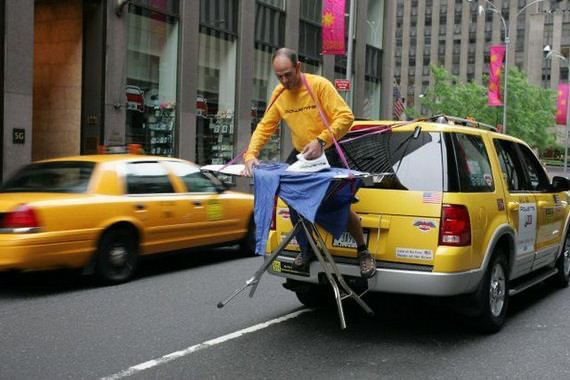

In [ ]:
image_file = "https://llava.hliu.cc/file=/nobackup/haotian/code/LLaVA/llava/serve/examples/extreme_ironing.jpg"

load_image(image_file)

In [ ]:
query = "이미지에 대해 설명해주세요."

inference(query, image_file)

'이 이미지에는 한 남성이 옷을 말리는 작업을 하는 동안 자동차 뒷좌석에 앉아 있는 모습이 담겨 있습니다. 그는 옷을 말리는 동안 편안하게 앉을 수 있도록 옷을 걸어 올려놓고 있습니다. 이 장면은 배경에 노란색 택시가 있는 도시 거리에서 벌어지고 있습니다. \n\n또한 이 장면에는 두 대의 자동차가 있는데, 한 대는 남성이 옷을 말리는 데 사용하고 있고 다른 한 대는 배경에 있습니다. 또한 이미지 왼쪽 근처에 신호등이 있어 도시 배경을 더욱 강조합니다.'

이 이미지에는 한 남성이 옷을 말리는 작업을 하는 동안 자동차 뒷좌석에 앉아 있는 모습이 담겨 있습니다. 그는 옷을 말리는 동안 편안하게 앉을 수 있도록 옷을 걸어 올려놓고 있습니다. 이 장면은 배경에 노란색 택시가 있는 도시 거리에서 벌어지고 있습니다.

또한 이 장면에는 두 대의 자동차가 있는데, 한 대는 남성이 옷을 말리는 데 사용하고 있고 다른 한 대는 배경에 있습니다. 또한 이미지 왼쪽 근처에 신호등이 있어 도시 배경을 더욱 강조합니다.

In [ ]:
query = "노란색 옷을 입은 남자는 무엇을 하고 있나요?"

inference(query, image_file)

'노란색 옷을 입은 남자가 차량 위에 올라타서 옷을 말리고 있습니다.'

In [ ]:
query = "노란색 옷을 입은 남자는 손에 무엇을 들고 있나요?"

inference(query, image_file)

'노란색 옷을 입은 남자는 손에 접이식 탱크를 들고 있습니다.'

In [ ]:
query = "이미지 안에는 몇 대의 차량이 있나요?"

inference(query, image_file)

'이미지에 차량이 두 대 있습니다.'

In [ ]:
query = "이미지에 나와있는 도시는 어디일까요?"

inference(query, image_file)

'이미지에 노란색 택시가 있는 것으로 보아 이 도시는 뉴욕일 가능성이 높습니다.'

## Inference 3

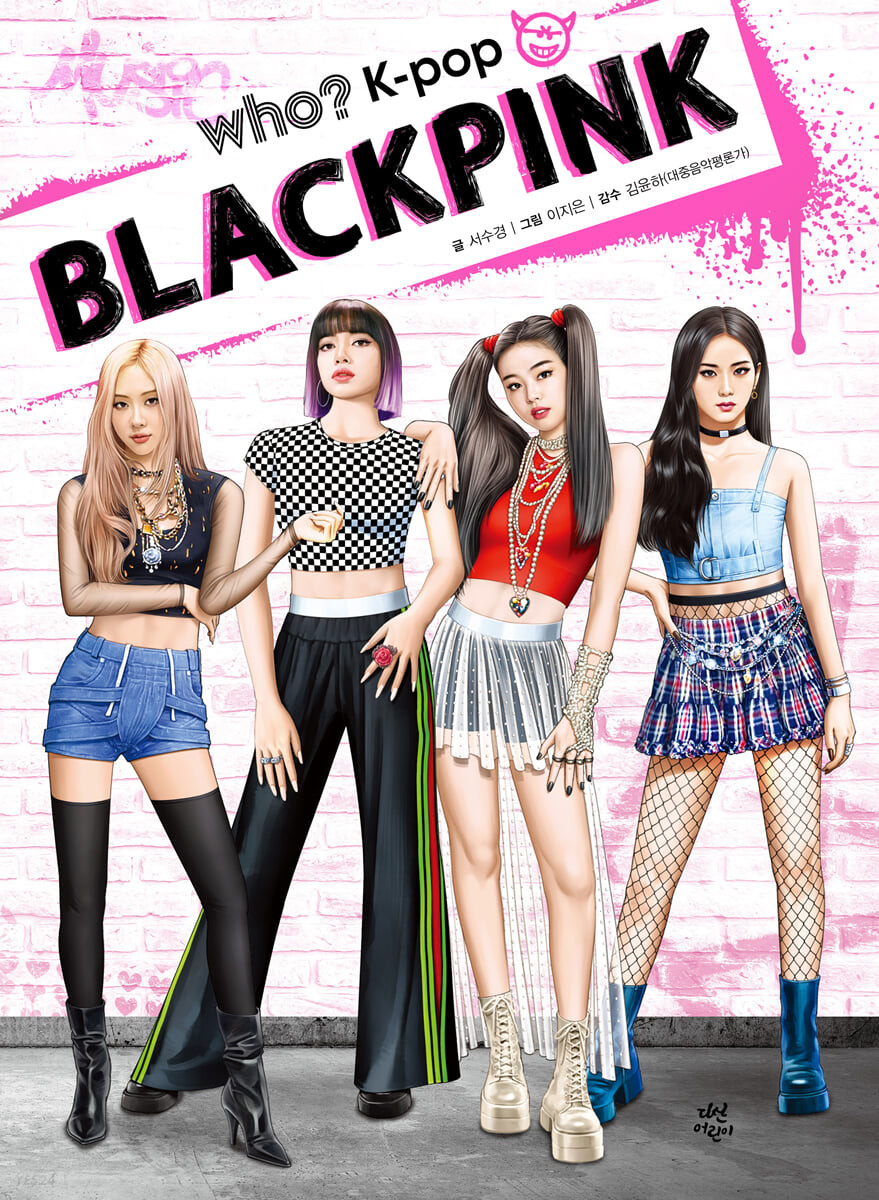

In [ ]:
image_file = "https://image.yes24.com/goods/104741361/XL"

load_image(image_file)

In [ ]:
query = "이미지를 설명해주세요."

inference(query, image_file)

'이 이미지에는 네 명의 여성이 벽돌 벽 앞에서 함께 포즈를 취하고 있습니다. 이들은 분홍색 셔츠를 입고 있으며, 각 여성은 독특한 외모를 가지고 있습니다. 이들은 친구 또는 동료로 보이며 함께 즐거운 시간을 보내고 있는 것처럼 보입니다.'

이 이미지에는 네 명의 여성이 벽돌 벽 앞에서 함께 포즈를 취하고 있습니다. 이들은 분홍색 셔츠를 입고 있으며, 각 여성은 독특한 외모를 가지고 있습니다. 이들은 친구 또는 동료로 보이며 함께 즐거운 시간을 보내고 있는 것처럼 보입니다.

In [ ]:
query = "이미지에 나와있는 사람들은 어느 나라 사람인가요?"

inference(query, image_file)

'이미지에 있는 사람들은 미국 캘리포니아 출신입니다.'

In [ ]:
query = "이 사람들이 왜 미국 캘리포니아 출신이라고 생각하나요?"

inference(query, image_file)

'이미지에서 네 명의 여성이 미국 캘리포니아 출신으로 묘사되어 있습니다. 이 여성들은 캘리포니아 브랜드인 플레이스 브랜드 의류를 입고 있습니다. 이들의 옷차림과 플레이스 브랜드 의류를 보면 캘리포니아 패션 트렌드와 패션 스타일을 반영하는 것으로 보아 캘리포니아 출신으로 추정할 수 있습니다. 또한 이 여성들은 플레이스 브랜드 의류를 입고 있기 때문에 캘리포니아 패션 업계에 종사하거나 관련이 있을 수 있으며, 이는 캘리포니아 출신임을 더욱 뒷받침합니다.'

이미지에서 네 명의 여성이 미국 캘리포니아 출신으로 묘사되어 있습니다. 이 여성들은 캘리포니아 브랜드인 플레이스 브랜드 의류를 입고 있습니다. 이들의 옷차림과 플레이스 브랜드 의류를 보면 캘리포니아 패션 트렌드와 패션 스타일을 반영하는 것으로 보아 캘리포니아 출신으로 추정할 수 있습니다. 또한 이 여성들은 플레이스 브랜드 의류를 입고 있기 때문에 캘리포니아 패션 업계에 종사하거나 관련이 있을 수 있으며, 이는 캘리포니아 출신임을 더욱 뒷받침합니다.

In [ ]:
query = "이 사람들은 아이돌 그룹입니다. 이 그룹의 이름은?"

inference(query, image_file)

'이 그룹의 이름은 "피카츄"입니다.'

In [ ]:
query = "영어로 뭐라고 써있나요?"

inference(query, image_file)

'영어로 말하면 "피카츄 프랜차이즈 캐릭터 그룹 사진"입니다.'